<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. Решение
## <center> Анализ временных рядов

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.0.8


## Подготавливаем данные

In [2]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

## Предсказываем с помощью FB Prophet
Будем обучаться на первых 5 месяцах и предсказывать число поездок за июнь.

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [8]:
train_df = df[:-predictions].copy()

In [9]:
m = Prophet()
m.fit(train_df);

In [10]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [11]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
378,2016-01-16,1.073446,2946.091778,-460.818755,-460.818755,2946.091771,2946.091785,2144.872305,2861.690820,-860.484941,-860.484941,-860.484941,399.666186,399.666186,399.666186,-460.818755,2485.273023
379,2016-01-17,1.076271,2949.096324,-303.307624,-303.307624,2949.096316,2949.096331,2283.386572,2989.173520,-720.184556,-720.184556,-720.184556,416.876932,416.876932,416.876932,-303.307624,2645.788700
380,2016-01-18,1.079096,2952.100870,714.117189,714.117189,2952.100862,2952.100878,3324.512877,4031.009920,282.582855,282.582855,282.582855,431.534334,431.534334,431.534334,714.117189,3666.218059
381,2016-01-19,1.081921,2955.105416,981.619602,981.619602,2955.105407,2955.105425,3580.889440,4307.355575,538.093426,538.093426,538.093426,443.526177,443.526177,443.526177,981.619602,3936.725019
382,2016-01-20,1.084746,2958.109962,874.491161,874.491161,2958.109953,2958.109971,3477.540795,4208.757829,421.712240,421.712240,421.712240,452.778920,452.778920,452.778920,874.491161,3832.601123


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

**Ответ:** 3833

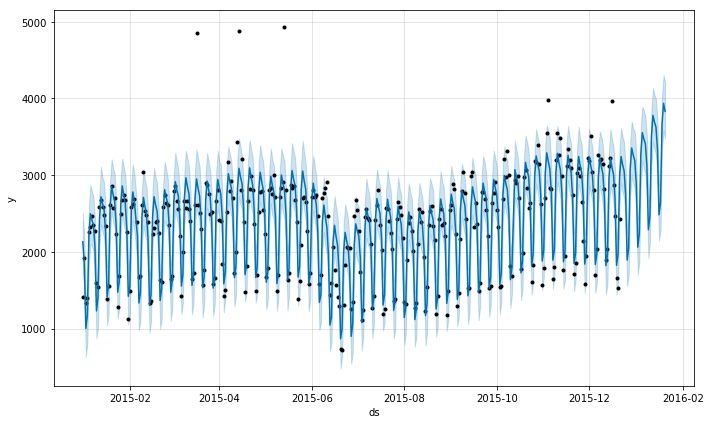

In [12]:
m.plot(forecast)

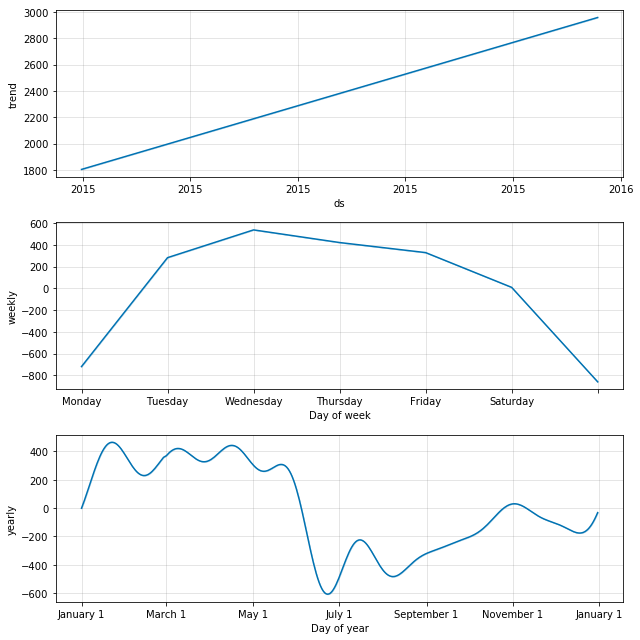

In [13]:
m.plot_components(forecast)

In [14]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [15]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predictions:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predictions:]['e'])), 2))

MAPE =  38.38
MAE =  712.86


Оценим качество предсказания по последним 30 точкам.

**Вопрос 2**: Какое получилось MAPE?

**Ответ:** 38.38

**Вопрос 3**: Какое получилось MAE?

**Ответ:** 712.86

## Предсказываем с помощью ARIMA

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

Критерий Дики-Фуллера: p=0.107392


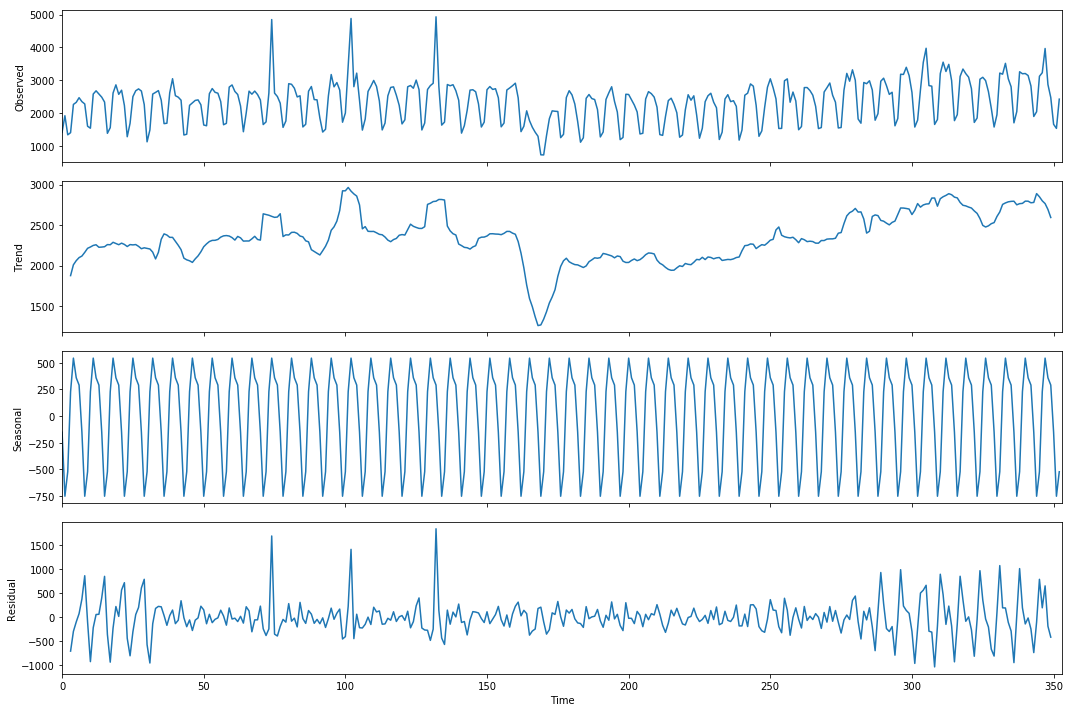

In [17]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [18]:
train_df.set_index('ds', inplace=True)

Критерий Дики-Фуллера: p=0.000000


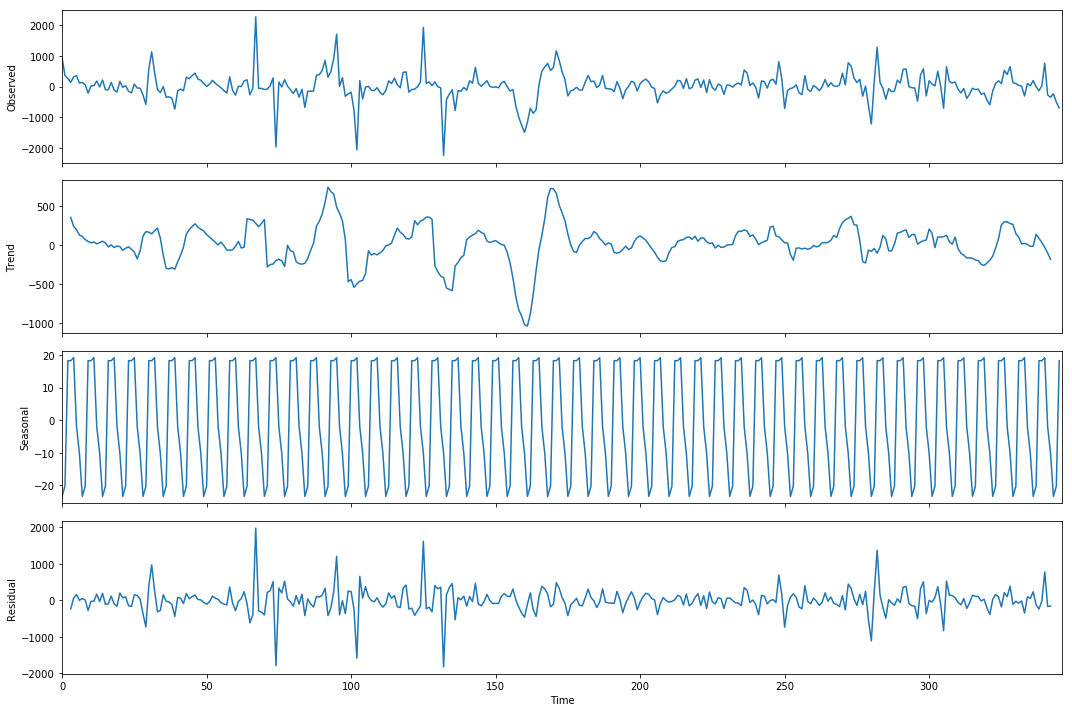

In [19]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

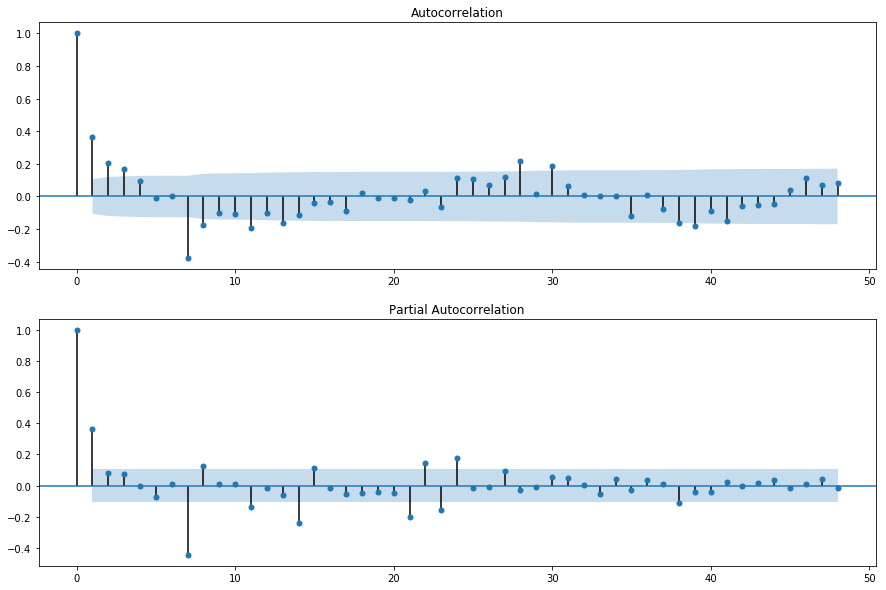

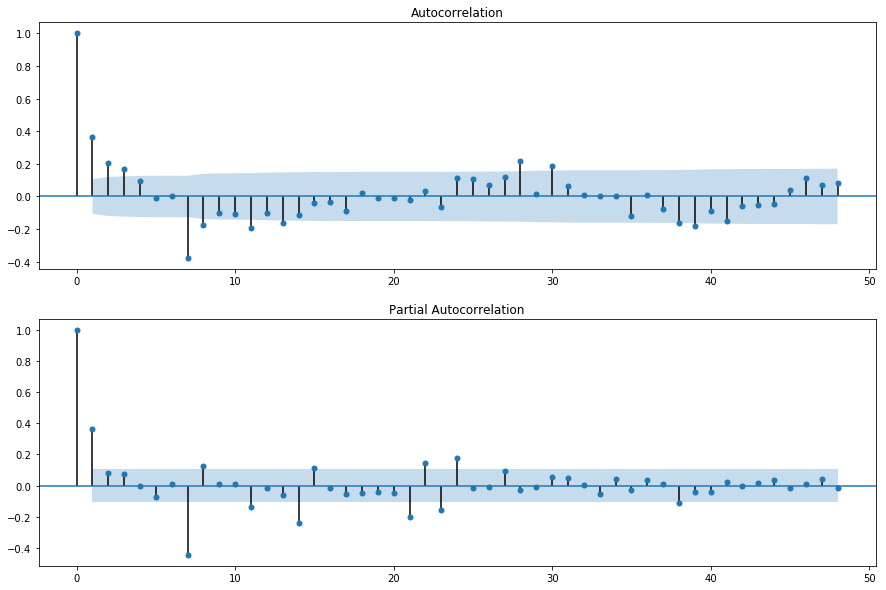

In [20]:

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)


Начальные приближения:
* Q = 1
* q = 3
* P = 3
* p = 1

In [21]:
ps = range(0, 2)
d=0
qs = range(0, 4)
Ps = range(0, 4)
D=1
Qs = range(0, 2)

In [22]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [23]:
%%time
import warnings
from tqdm import tqdm
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')


for param in tqdm(parameters_list):
#     print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.y, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
#         print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 64/64 [00:37<00:00,  1.62s/it]

CPU times: user 1min 13s, sys: 1.56 s, total: 1min 15s
Wall time: 37.5 s


In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
53  (1, 2, 3, 0)  5022.312525
54  (1, 2, 3, 1)  5022.982338
61  (1, 3, 3, 0)  5024.124871
38  (1, 0, 3, 1)  5025.130945
62  (1, 3, 3, 1)  5025.166260


**Вопрос 5**: Модель SARIMAX c какими параметрами лучшая по AIC-критерию?

In [25]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 1, 0, 7)   Log Likelihood               -2504.156
Date:                           Mon, 15 May 2017   AIC                           5022.313
Time:                                   16:38:09   BIC                           5049.378
Sample:                               01-01-2015   HQIC                          5033.082
                                    - 12-21-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8633      0.092      9.346      0.000       0.682       1.044
ma.L1         -0.4015      0.101     -3.979

Критерий Стьюдента: p=0.535932
Критерий Дики-Фуллера: p=0.000000


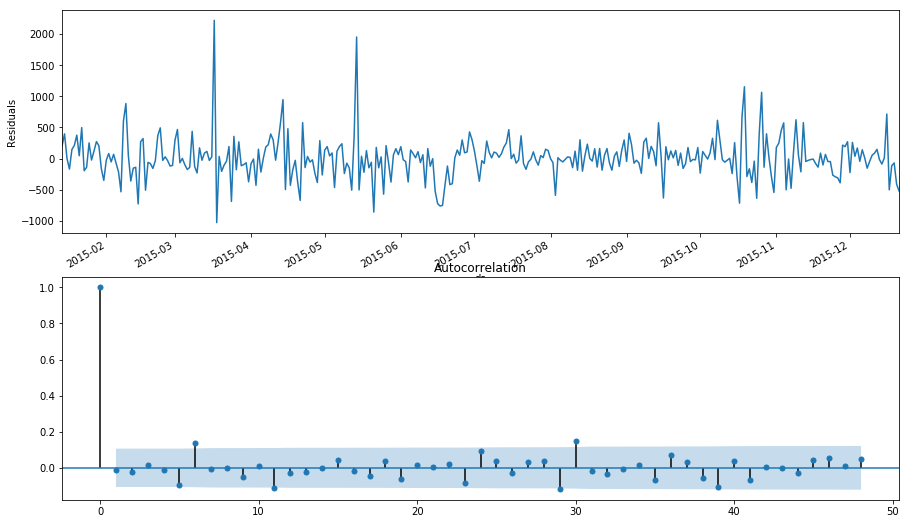

In [26]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

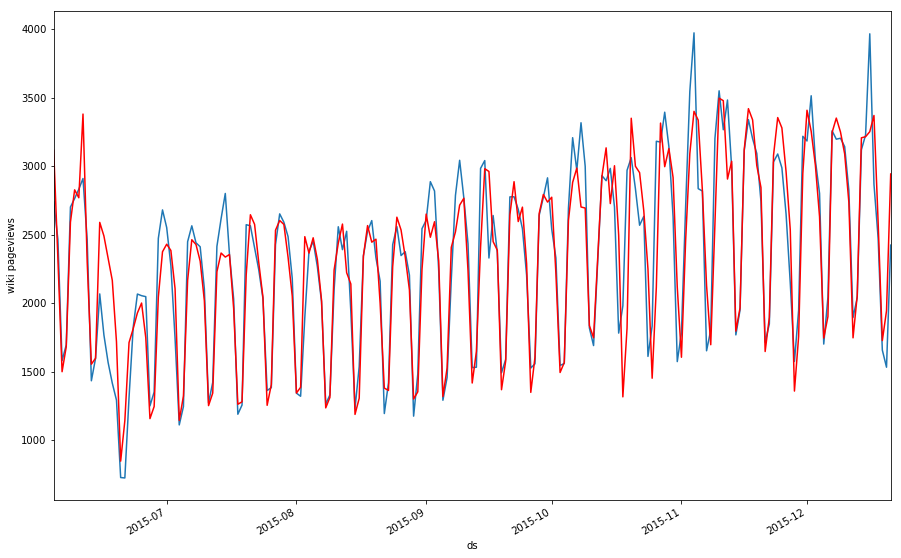

In [27]:
train_df['arima_model'] = best_model.fittedvalues

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('wiki pageviews');